In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import numpy as np
import nltk
import math
from collections import Counter 
from math import log2
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%run data_intake.ipynb
import os

In [77]:
aquastat_file_names = [fn for fn in os.listdir("data/") if ".xlsx" in fn]

aquastat_crop_yeild = pipeline(aquastat_file_names, "Attainable_yields.csv", "value")

# For this decision tree regression, it's easiest if all the feature variables are numbers
# In a sense, the country distinction is still retained given the order
aquastat_crop_yeild_dropped = aquastat_crop_yeild.drop('Country', axis=1)

In [31]:
def tree_mean_squared_error(left_split, right_split):
    residual = np.concatenate((left_split, right_split), axis=None)
    squared_diff = residual ** 2
    squared_diff_sum = np.sum(residual)
    return squared_diff_sum / len(right_split) 


def split(df, split_col, v):
    """
    Subdivides the dataframe based on the choosen split_column and value partition
    """ 
    left_split = df[df[split_col] <= v]
    right_split = df[df[split_col] > v]
    return left_split, right_split
    


def get_best_split(df, class_col, target_impurity):
    """
    Returns information for a split of the dataset based on the choosen method (gini or other),
    including the right and left partitions of the dataframe
    """
    # Holder variables for the information regarding our best split of the df
    best_col = 0
    best_v = ''
    best_meas = float("inf")
    best_split_left = None
    best_split_right = None
    
    # Loop through all the feature columns
    for split_col in df.columns:
        # Make sure it's not the class column
        if split_col != class_col:
            # Find all the unique values in the feature column
            for v in set(df[split_col]):
                # Create a split w/ the values greater than or equal to or less than for left and right splits
                split_left, split_right = split(df, split_col, v)
                
                # Make sure we aren't taking the MSE of empty splits
                if len(split_left)>0 and len(split_right)>0:
                    
                    # Take the mean of both of our splits (used for calculating MSE)
                    left_mean = np.mean(split_left.values)
                    right_mean = np.mean(split_right.values)
                    
                    # Calculate each sides residuals
                    res_left = split_left - left_mean 
                    res_right = split_right - right_mean
                    
                    # Find feature value using MSE for the joint residuals
                    meas = tree_mean_squared_error(res_left, res_right)
                    
                    # Does this feature value represent the lowest MSE?
                    if meas < best_meas and meas > target_impurity:
                        best_meas = meas
                        best_col = split_col
                        best_v = v
                        best_split_left = split_left
                        best_split_right = split_right

    return best_col, best_v, best_meas, best_split_left, best_split_right
                    


def compute_majority_class(df, class_col):
    """
    Compute the majority class for this node
    """
    # Count the number of each unique class in the class column
    counts = Counter(df[class_col])
    majority_class = None
    # Holder variable to keep track of the number of occurences of the majority class
    max_count = 0
    # Iterate through the counts tuple, find the majority class
    for k,v in counts.items():
        if v > max_count:
            max_count = v
            majority_class = k
    return majority_class
        

In [32]:
def dtree(train, max_depth=None, current_depth=0, min_instances=2, target_impurity=0.0):
    """
    Constructs binary decision tree based on the input parameters
    """
    # If the input dataset is empty at this point in recursion, we have hit a return leaf
    if train is None or len(train) == 0:
        return None
    # If the input dataset is smaller than our min number of instances or the max depth has been exceeded, return leaf
    elif len(train) < min_instances or current_depth == max_depth:
        return None
    
    # Generate the best split for this input dataset
    best_col, best_v, best_meas, left_subtree, right_subtree = get_best_split(
        train, "total_yield", target_impurity)
    
    # The split with the best measusure must have had an empty side, so we have to terminate to a leaf  
    # Or no best measure was found (stops infinite recursion)
    if best_meas == float("inf"):
        return None

    # Recursive formulation of building the decision tree
    return (best_col, best_v, len(train), compute_majority_class(train, "total_yield"), best_meas, current_depth,
                dtree(left_subtree, max_depth, current_depth + 1, min_instances, target_impurity),
                dtree(right_subtree, max_depth, current_depth + 1, min_instances, target_impurity))


In [33]:
#aquastat_crop_yeild = aquastat_crop_yeild.drop('Country', axis=1)
test_tree = dtree(aquastat_crop_yeild_dropped[0:200], max_depth=None, target_impurity=0.0)
test_tree

('total_population',
 5402.761,
 200,
 0.0,
 2.1719276460249032e-13,
 0,
 ('gdp_per_capita',
  1114.514374,
  66,
  0.0,
  2.4664263098926867e-13,
  1,
  ('gdp_per_capita',
   821.321124,
   7,
   57.68,
   1.5158245029548803e-13,
   2,
   ('total_internal_renewable_water_resource_per_capita',
    8647.6213254842,
    4,
    56.65999999999998,
    1.8189894035458565e-12,
    3,
    ('Year',
     1994,
     3,
     56.65999999999998,
     3.410605131648481e-12,
     4,
     None,
     ('Year',
      1995,
      2,
      56.65999999999998,
      1.8189894035458565e-12,
      5,
      None,
      None)),
    None),
   ('agricultural_value_added_percent_of_gdp',
    24.515361,
    3,
    57.68,
    1.0231815394945443e-12,
    3,
    None,
    None)),
  ('total_population_with_access_to_safe_drinking_water',
   95.1,
   59,
   0.0,
   2.6947991163642317e-13,
   2,
   ('gdp_per_capita',
    4109.340457,
    5,
    87.14,
    1.5158245029548803e-13,
    3,
    ('Year',
     2015,
     2,
    

In [60]:
####### PART B #########

def mean_squared_error(y, y_pred):
    diff = np.array(y) - np.array(y_pred)
    squared_diff = np.square(diff)
    squared_diff_sum = squared_diff.sum()
    return squared_diff_sum / len(y) 

def mean_absolute_error(y, y_pred):
    diff = np.array(y) - np.array(y_pred)
    abs_diff = np.absolute(diff)
    abs_diff_sum = abs_diff.sum()
    return abs_diff_sum / len(y)

def r_squared_score(y, y_pred):
    corr_matrix = np.corrcoef(y, y_pred)
    corr = corr_matrix[0,1]
    r_sq = corr**2
    return r_sq
    

# Because of tuple formultion, the information that each node contains is hardcoded in these functions

def get_feature_column(model):
    """
    Returns the split feature for this node
    """
    return model[0]

def get_best_val_for_node(model):
    """
    Returns the split feature value for this node
    """
    return model[1]

def get_node_majority_class(model):
    """
    Returns the majority class of the samples that reached that node
    """
    return model[3]

def get_left_tree(model):
    """
    Returns the left tree from this node
    """
    return model[6]

def get_right_tree(model):
    """
    Returns the right tree from this node
    """
    return model[7]


def btree_search(model, row):
    """
    Search resurviely through our binary decision tree
    """
    
    # Pick apart important values from each node in the tree, including left and right trees
    feature_col = get_feature_column(model)
    best_val = get_best_val_for_node(model)
    majority_class = get_node_majority_class(model)
    left_tree = get_left_tree(model)
    right_tree = get_right_tree(model)
    
    # Left side of the tree
    if row[feature_col] <= best_val:
        # If we haven't hit a leaf, continue recursing through the left part of the tree
        if left_tree is not None:
            return btree_search(left_tree, row)
        else:
            # We hit a leaf so we return the majority class for this node as our prediction
            return majority_class
    # Right side of the tree
    else:
        # If we haven't hit a leaf, continue recursing through the right part of the tree
        if right_tree is not None:
            return btree_search(right_tree, row)
        else:
            # We hit a leaf so we return the majority class for this node as our prediction
            return majority_class
            
    

def predict(model, data):
    """
    Uses the tree (model) and a dataframe to make predictions using the tree
    """
    # Holder list for the predictions
    predictions = list()
    
    # Iterate through every row (datapoint) in the dataset
    for i in range(len(data)):
        # Fetch the specific row
        row = data.iloc[i]
        # Make a prediction using this row (by recursing through the tree)
        pred = btree_search(model, row)
        # Add this prediction to the list of predictions
        predictions.append(pred)
    
    return predictions


def k_fold_cross_validation(k, data, max_depth, min_instances, target_impurity):
    """
    Runs k fold cross validation on a given data set
    """
    # Holder array for the MSE and the accompnaying regression tree so we an output the best one
    MSE_and_tree = dict()
    
    # Loop through all the k values
    for f in range(k):
        # Partition our data into a training and validation fold
        train_fold = data[data.index % k != f]
        valid_fold = data[data.index % k == f]
        
        # Generate the model based on a selection of criteria
        model = dtree(train_fold, max_depth=max_depth, 
                      min_instances=min_instances, target_impurity=target_impurity)
        # Make predictions using the validation data
        preds = predict(model, valid_fold)
        
        y = np.array(valid_fold['total_yield'])
        ypred = np.array(preds)
        
        # Measure the accuracy of those predictions
        MSE = mean_squared_error(y, ypred)
        MAB = mean_absolute_error(y, ypred)
        r2 = r_squared_score(y, ypred)
        
        MSE_and_tree[f] = [MSE, MAB, r2, model]

    return MSE_and_tree


def get_best_model_k_fold_cross_validation(k, data, max_depth, min_instances, target_impurity):
    MSE_and_tree = k_fold_cross_validation(k, data, max_depth, min_instances, target_impurity)
    
    max_r2 = -float("inf")
    best_model = None
    best_MSE = None
    best_MAB = None
    for val in MSE_and_tree.values():
        if val[2] > max_r2:
            max_r2 = val[2]
            best_model = val[3]
            best_mab = val[1]
            best_MSE = val[0]
    
    return max_r2, best_MSE, best_mab, best_model


In [52]:
predict(test_tree, aquastat_crop_yeild_dropped[0:10])

[87.14,
 87.14,
 68.46000000000001,
 68.46000000000001,
 87.14,
 65.91,
 65.09,
 65.91,
 63.46,
 63.46]

In [34]:
aquastat_crop_yeild[0:10]['total_yield']

59    87.14
60    69.81
61    68.46
62    71.04
63    68.50
64    65.91
65    65.09
66    64.84
67    63.46
68    61.71
Name: total_yield, dtype: float64

In [69]:
max_r2, MSE, MAB, best_model = get_best_model_k_fold_cross_validation(10, aquastat_crop_yeild_dropped, max_depth=None, min_instances=2, target_impurity=0.0)

In [70]:
def plot_actual_vs_predicted_yield(data, best_model):
    plt.figure(figsize = (15,10))
    plt.scatter(np.arange(0, len(data)), predict(best_model, data), label="predicted_yield")
    plt.scatter(np.arange(0, len(data)), data['total_yield'], label="actual_yield")
    leg = plt.legend(loc='upper center')
    plt.xlabel('sample #')
    plt.ylabel('total crop yield')
    plt.show()

MSE: 551.4905991150442
MAB: 12.95778761061947
R2: 0.7617019040528107


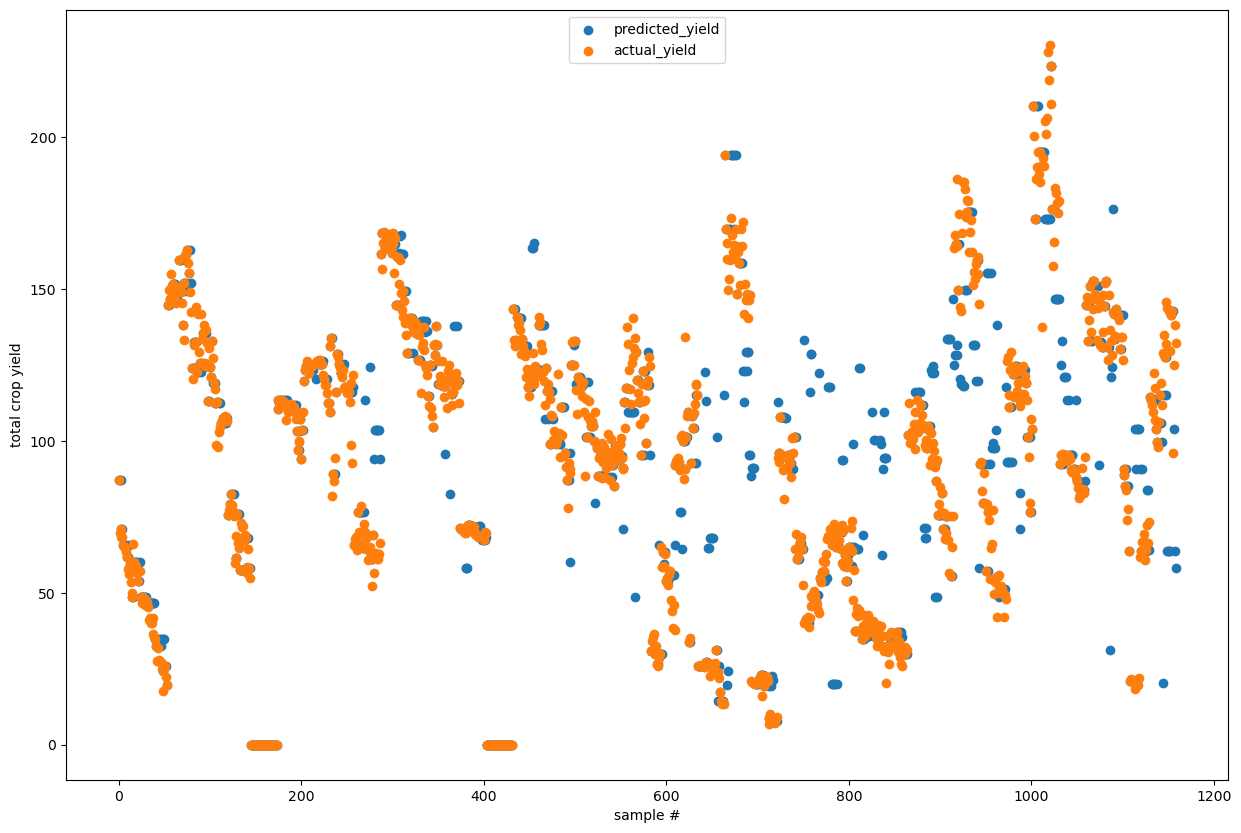

In [78]:
print(f"MSE: {MSE}")
print(f"MAB: {MAB}")
print(f"R2: {max_r2}")
plot_actual_vs_predicted_yield(aquastat_crop_yeild_dropped, best_model)

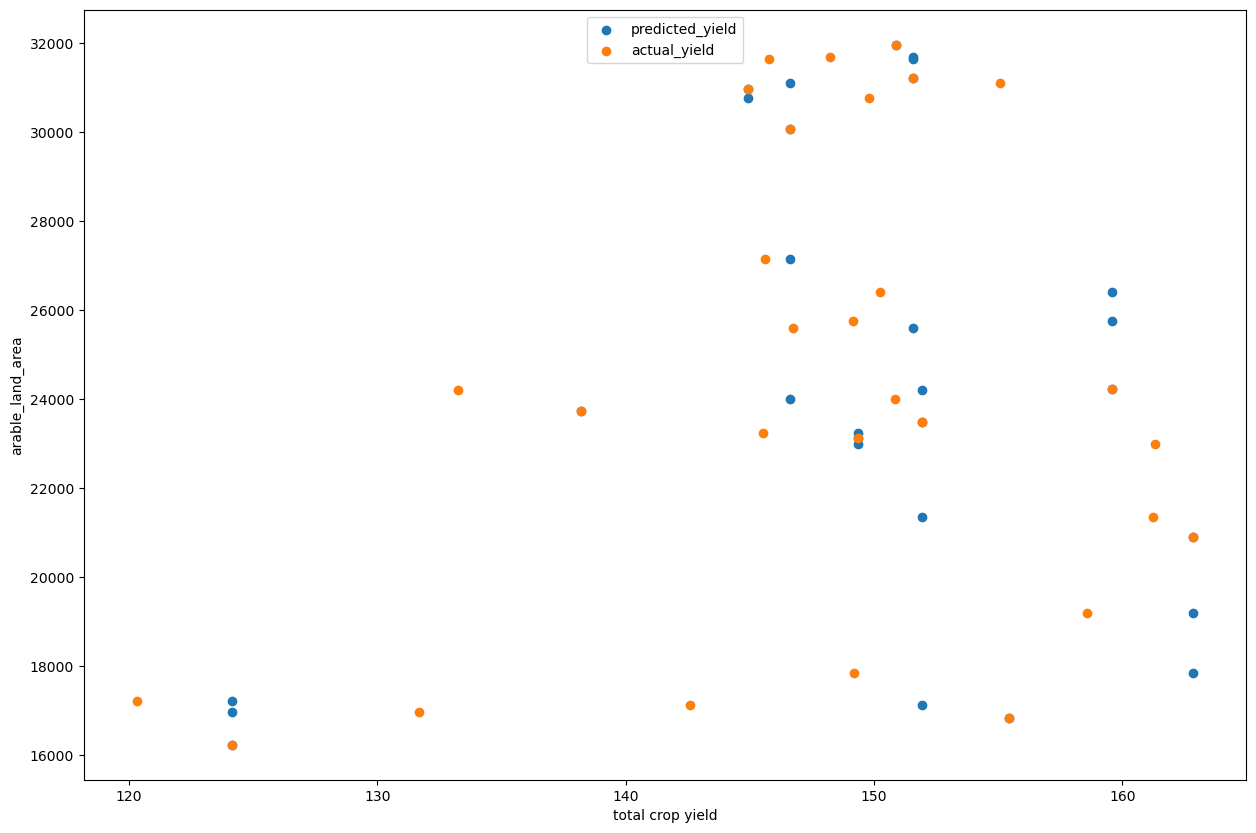

In [92]:
def plot_feature_vs_crop_yield(data, feature, best_model):
    plt.figure(figsize = (15,10))
    plt.scatter(predict(best_model, data), data[feature], label="predicted_yield")
    plt.scatter(data['total_yield'], data[feature], label="actual_yield")
    leg = plt.legend(loc='upper center')
    plt.xlabel('total crop yield')
    plt.ylabel(f'{feature}')
    plt.show()

data = aquastat_crop_yeild[aquastat_crop_yeild['Country'] == "Australia"]
plot_feature_vs_crop_yield(data, 'arable_land_area', best_model)

,Country,Year,total_renewable_water_resources,agricultural_value_added_percent_of_gdp,total_exploitable_water_resources,precipitation_index,gdp_per_capita,dam_capacity,total_population_with_access_to_safe_drinking_water,total_internal_renewable_water_resource_per_capita,arable_land_area,total_population,total_yield
430,Australia,2018,492.0,2.109870,190.0,717.100000,58596.826341,77.7863,100.0,19760.502707,30974.00,24898.152,144.91
431,Australia,2017,492.0,2.450340,190.0,717.100000,57628.863849,77.7863,100.0,20012.511888,30752.00,24584.620,149.80
432,Australia,2016,492.0,2.697786,190.0,717.100000,53996.626043,77.7863,100.0,20278.029925,30057.00,24262.712,146.62
433,Australia,2015,492.0,2.399932,190.0,717.100000,52131.381804,77.7863,100.0,20557.817148,31090.70,23932.502,155.08
434,Australia,2014,492.0,2.374060,190.0,717.100000,62062.138087,77.7863,100.0,20850.617026,31960.30,23596.424,150.89
435,Australia,2013,492.0,2.220978,190.0,717.100000,66360.873829,77.7863,100.0,21156.819636,31220.80,23254.913,151.58
436,Australia,2012,492.0,2.285936,190.0,717.100000,69451.238670,77.7863,100.0,21481.012793,31637.40,22903.948,145.78
437,Australia,2011,492.0,2.268620,190.0,717.100000,68625.825695,77.7863,100.0,21829.797594,31694.90,22538.001,148.24
438,Australia,2010,492.0,2.294543,190.0,717.100000,58654.114395,77.7863,100.0,22207.498470,25591.75,22154.679,146.75
439,Australia,2009,492.0,2.209019,190.0,717.100000,46657.287877,77.7863,100.0,22619.804623,27141.60,21750.851,145.60
